----

# <h1 style="text-align: center;">Statistic Under the Stars 2024 - Group SoloLacrime</h2>

----

| STUDENT | ID |
| :-: | :-: |
| Camilla Brigandi | 2055650 |
| Francesco Lazzari | 1917922 |  
| Riccardo Violano | 2148833 | 
| Matteo Pazzini | 1868953 |

In [1]:
import pandas as pd
from geopy import distance
import numpy as np
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Geopy_lib",timeout=10)
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/Users/francescolazzari/anaconda3/envs/Uni/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Import Datasets 
candidates_train = pd.read_csv('/Users/francescolazzari/Documents/Università - Data Science/SL/Homework/SUS/Data/candidates_train.csv')
candidates_test = pd.read_csv('/Users/francescolazzari/Documents/Università - Data Science/SL/Homework/SUS/Data/candidates_test.csv')
job_positions_train = pd.read_csv('/Users/francescolazzari/Documents/Università - Data Science/SL/Homework/SUS/Data/job_positions_train.csv')
job_positions_test = pd.read_csv('/Users/francescolazzari/Documents/Università - Data Science/SL/Homework/SUS/Data/job_positions_test.csv')
matches_train = pd.read_csv('/Users/francescolazzari/Documents/Università - Data Science/SL/Homework/SUS/Data/matches_train.csv')
matches_test = pd.read_csv('/Users/francescolazzari/Documents/Università - Data Science/SL/Homework/SUS/Data/matches_test.csv')

----

## <h2 style="text-align: center;">Preprocessing</h2>

----

Preprocessing on the `Train` Dataset.

In [3]:
# We need to fix the format of some features, in particular we want a list

def converti_in_lista(stringa):
    if pd.isna(stringa):
        return stringa
    return [elem.lower() for elem in stringa.split(';')]

#We apply the function to the features
candidates_train['Prof_cat_exp'] = candidates_train['Prof_cat_exp'].apply(converti_in_lista)
candidates_train['Prof_cat_int'] = candidates_train['Prof_cat_int'].apply(converti_in_lista)
candidates_train['Hard_skills_group'] = candidates_train['Hard_skills_group'].apply(converti_in_lista)
candidates_train['Soft_skills'] = candidates_train['Soft_skills'].apply(converti_in_lista)
candidates_train['Cards'] = candidates_train['Cards'].apply(converti_in_lista)
candidates_train['Education'] = candidates_train['Education'].apply(converti_in_lista)
candidates_train['Languages'] = candidates_train['Languages'].apply(converti_in_lista)

In [4]:
#Same thing for the other Dataset

job_positions_train['Prof_cat'] = job_positions_train['Prof_cat'].apply(converti_in_lista)
job_positions_train['Hard_skills_group'] = job_positions_train['Hard_skills_group'].apply(converti_in_lista)
job_positions_train['Soft_skills'] = job_positions_train['Soft_skills'].apply(converti_in_lista)
job_positions_train['Education'] = job_positions_train['Education'].apply(converti_in_lista)
job_positions_train['Languages'] = job_positions_train['Languages'].apply(converti_in_lista)
job_positions_train['Cards'] = job_positions_train['Cards'].apply(converti_in_lista)


In [5]:
# We saw that there were repetition for the gender, to simplify the evaluation we choosed to keep only, also because all the jobs are genderless

def remove_after_slash(s):
    return s.split('/')[0]

#if there will be NaN we will keep the NaN
def process_list(lst):
    if isinstance(lst, list):
        return [remove_after_slash(item) for item in lst]
    return lst  

candidates_train['Prof_cat_int'] = candidates_train['Prof_cat_int'].apply(process_list)
candidates_train['Prof_cat_exp'] = candidates_train['Prof_cat_exp'].apply(process_list)

In [6]:
# select rows where either 'Latitudine' or 'Longitudine' column has NaN values
# We wanted to full use the information about the distance so we updated the coordinates of the city weren't present
selected_rows = candidates_train[candidates_train['Latitudine'].isna() | candidates_train['Longitudine'].isna()]

# apply the geocode function
selected_rows["Latitudine"] = selected_rows["Domicile_City"].apply(lambda x: geolocator.geocode(x).latitude)
selected_rows["Longitudine"] = selected_rows["Domicile_City"].apply(lambda x: geolocator.geocode(x).longitude)

# update the cabdidates train dataset
candidates_train.update(selected_rows)

/var/folders/kb/y2wpyfkn7rj91tcfycy6yhlm0000gn/T/ipykernel_8618/3293493348.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows["Latitudine"] = selected_rows["Domicile_City"].apply(lambda x: geolocator.geocode(x).latitude)
/var/folders/kb/y2wpyfkn7rj91tcfycy6yhlm0000gn/T/ipykernel_8618/3293493348.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows["Longitudine"] = selected_rows["Domicile_City"].apply(lambda x: geolocator.geocode(x).longitude)


In [7]:
# We merged all the datasets to evaluate better the problem 

temporary_df = matches_train.merge(job_positions_train, on='Job_ID', how='left')
final_df=temporary_df.merge(candidates_train, on='CANDIDATE_ID',how='left')
final_df=final_df.drop(['Education_x','Education_y'],axis=1)

In [8]:
# We choosed to create new features that will consider the correlation between the candidates and the Job_list

def check_languages(x): # BOOLEAN
    if x['Languages_x'] == 0:
        return 1  # If the requisites are NaN we will say that they will be respected
    # We check if we have all the languages that are requested for the job
    if isinstance(x['Languages_x'], list) and isinstance(x['Languages_y'], list):
        if all(lang in x['Languages_y'] for lang in x['Languages_x']):
            return 1  
    
    return 0  

def check_cards(x): # BOOLEAN
    if x['Cards_x'] == 0:
        return 1 # If the requisites are NaN we will say that they will be respected
    # We check if we have all the cards that are requested for the job
    if isinstance(x['Cards_x'], list) and isinstance(x['Cards_y'], list):
        if all(lang in x['Cards_y'] for lang in x['Cards_x']):
            return 1  
    
    return 0  


# We created a feature for the distance from the Job
def calculate_distance(row):
    try:
        if np.isnan(row['Latitudine_x']) or np.isnan(row['Longitudine_x']) or np.isnan(row['Latitudine_y']) or np.isnan(row['Longitudine_y']):
            return np.nan
        else:
            return distance.distance((row['Latitudine_x'], row['Longitudine_x']), (row['Latitudine_y'], row['Longitudine_y'])).kilometers
    except:
        return np.nan
    
def check_experience(x):# BOOLEAN
    # We check if the Candidate has already worked in the sector
    if isinstance(x['Prof_cat'], list) and isinstance(x['Prof_cat_exp'], list):
        if all(lang in x['Prof_cat_exp'] for lang in x['Prof_cat']):
            return 1  
    
    return 0  

def check_intent(x):# BOOLEAN
        # We check if the Candidate wants to work in the sector

    if isinstance(x['Prof_cat'], list) and isinstance(x['Prof_cat_int'], list):
        if all(lang in x['Prof_cat_int'] for lang in x['Prof_cat']):
            return 1 
    
    return 0  


# To Evaluate the compatility with the job we calculate how many skills requested in the job are present in the skills of the candidate
def count_common_elements(row):
    if isinstance(row['Hard_skills_group_y'], list) and isinstance(row['Hard_skills_group_x'], list):
        count = sum(1 for elem in row['Hard_skills_group_y'] if elem in row['Hard_skills_group_x'])
        return count / len(row['Hard_skills_group_x']) if len(row['Hard_skills_group_x']) != 0 else 0
    else:
        return 0
    
def count_common_elements2(row):
    if isinstance(row['Soft_skills_y'], list) and isinstance(row['Soft_skills_x'], list):
        count = sum(1 for elem in row['Soft_skills_y'] if elem in row['Soft_skills_x'])
        return count / len(row['Soft_skills_x']) if len(row['Soft_skills_x']) != 0 else 0
    else:
        return 0

In [9]:
# Handling of the NaN
# we substituted all the NaN values with 0

final_df['Languages_y'] = final_df['Languages_y'].fillna(0)
final_df['Languages_x'] = final_df['Languages_x'].fillna(0)

final_df['Cards_y'] = final_df['Cards_y'].fillna(0)
final_df['Cards_x'] = final_df['Cards_x'].fillna(0)

In [10]:
# Creation of new features applying the funcions that we created

final_df['language_check'] = final_df.apply(check_languages, axis=1)
final_df['cards_check'] = final_df.apply(check_cards, axis=1)
final_df['Prof_cat']=final_df['Prof_cat'].apply(process_list)
final_df['position_work'] = final_df[['Latitudine_x', 'Longitudine_x']].apply(tuple, axis=1)
final_df['living_position'] = final_df[['Latitudine_y', 'Longitudine_y']].apply(tuple, axis=1)
final_df['distance'] = final_df.apply(calculate_distance, axis=1)
final_df['exp_check'] = final_df.apply(check_experience, axis=1)
final_df['int_check'] = final_df.apply(check_intent, axis=1)
final_df['percentual_skill'] = final_df.apply(count_common_elements, axis=1)
final_df['percentual_skill_2'] = final_df.apply(count_common_elements2, axis=1)


In [11]:
# Drop of useless features

final_df=final_df.drop(['Languages_x','Languages_y','Cards_x','Cards_y','Prof_cat_exp','Prof_cat','Prof_cat_int','Hard_skills_group_x','Latitudine_x','Longitudine_x','Hard_skills_group_y','Latitudine_y','Longitudine_y','Soft_skills_x','Soft_skills_y','position_work','living_position','Work_city','Domicile_City'],axis=1)

In [12]:
final_df

,Job_ID,CANDIDATE_ID,Match,language_check,cards_check,distance,exp_check,int_check,percentual_skill,percentual_skill_2
0,0264_22927,1933502,1,1,1,2.132536,1,0,0.0,0.000000
1,0553_22671,6016478,1,0,1,8.776457,1,1,0.0,0.000000
2,1354_730,6167354,1,1,1,6.306923,1,1,1.0,0.000000
3,1526_995,5883294,1,1,1,16.582831,1,0,0.0,0.000000
4,0130_11963,5848616,1,0,1,6.750027,1,1,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
12650,0178_21171,5011230,0,1,1,29.672182,1,0,0.0,0.666667
12651,0070_20302,2214010,0,1,1,25.352334,1,0,1.0,0.200000
12652,0349_15070,7638353,0,1,1,9.996768,0,0,0.0,0.000000
12653,0509_16576,3451059,0,1,1,12.045153,0,0,0.0,0.333333


---

Now we are going to do exactly the same preprocessing steps for the `Test` Dataset.

In [13]:
### TEST SET
candidates_test['Prof_cat_exp'] = candidates_test['Prof_cat_exp'].apply(converti_in_lista)
candidates_test['Prof_cat_int'] = candidates_test['Prof_cat_int'].apply(converti_in_lista)
candidates_test['Hard_skills_group'] = candidates_test['Hard_skills_group'].apply(converti_in_lista)
candidates_test['Soft_skills'] = candidates_test['Soft_skills'].apply(converti_in_lista)
candidates_test['Cards'] = candidates_test['Cards'].apply(converti_in_lista)
candidates_test['Education'] = candidates_test['Education'].apply(converti_in_lista)
candidates_test['Languages'] = candidates_test['Languages'].apply(converti_in_lista)

job_positions_test['Prof_cat'] = job_positions_test['Prof_cat'].apply(converti_in_lista)
job_positions_test['Hard_skills_group'] = job_positions_test['Hard_skills_group'].apply(converti_in_lista)
job_positions_test['Soft_skills'] = job_positions_test['Soft_skills'].apply(converti_in_lista)
job_positions_test['Education'] = job_positions_test['Education'].apply(converti_in_lista)
job_positions_test['Languages'] = job_positions_test['Languages'].apply(converti_in_lista)
job_positions_test['Cards'] = job_positions_test['Cards'].apply(converti_in_lista)

In [14]:
candidates_test['Prof_cat_int'] = candidates_test['Prof_cat_int'].apply(process_list)
candidates_test['Prof_cat_exp'] = candidates_test['Prof_cat_exp'].apply(process_list)

In [15]:
selected_rows = candidates_test[candidates_test['Latitudine'].isna() | candidates_test['Longitudine'].isna()]
# apply the geocode function
selected_rows["Latitudine"] = selected_rows["Domicile_City"].apply(lambda x: geolocator.geocode(x).latitude)
selected_rows["Longitudine"] = selected_rows["Domicile_City"].apply(lambda x: geolocator.geocode(x).longitude)
# update the cabdidates train dataset
candidates_test.update(selected_rows)

/var/folders/kb/y2wpyfkn7rj91tcfycy6yhlm0000gn/T/ipykernel_8618/4264919059.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows["Latitudine"] = selected_rows["Domicile_City"].apply(lambda x: geolocator.geocode(x).latitude)
/var/folders/kb/y2wpyfkn7rj91tcfycy6yhlm0000gn/T/ipykernel_8618/4264919059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows["Longitudine"] = selected_rows["Domicile_City"].apply(lambda x: geolocator.geocode(x).longitude)


In [16]:
temporary_df = matches_test.merge(job_positions_test, on='Job_ID', how='left')
final_df_test=temporary_df.merge(candidates_test, on='CANDIDATE_ID',how='left')
final_df_test=final_df_test.drop(['Education_x','Education_y'],axis=1)

In [17]:
final_df_test['Languages_y'] = final_df_test['Languages_y'].fillna(0)
final_df_test['Languages_x'] = final_df_test['Languages_x'].fillna(0)

final_df_test['Cards_y'] = final_df_test['Cards_y'].fillna(0)
final_df_test['Cards_x'] = final_df_test['Cards_x'].fillna(0)

In [18]:

final_df_test['language_check'] = final_df_test.apply(check_languages, axis=1)
final_df_test['cards_check'] = final_df_test.apply(check_cards, axis=1)
final_df_test['Prof_cat']=final_df_test['Prof_cat'].apply(process_list)
final_df_test['position_work'] = final_df_test[['Latitudine_x', 'Longitudine_x']].apply(tuple, axis=1)
final_df_test['living_position'] = final_df_test[['Latitudine_y', 'Longitudine_y']].apply(tuple, axis=1)
final_df_test['distance'] = final_df_test.apply(calculate_distance, axis=1)
final_df_test['exp_check'] = final_df_test.apply(check_experience, axis=1)
final_df_test['int_check'] = final_df_test.apply(check_intent, axis=1)
final_df_test['percentual_skill'] = final_df_test.apply(count_common_elements, axis=1)
final_df_test['percentual_skill_2'] = final_df_test.apply(count_common_elements2, axis=1)


In [19]:
final_df_test=final_df_test.drop(['Languages_x','Languages_y','Cards_x','Cards_y','Prof_cat_exp','Prof_cat','Prof_cat_int','Hard_skills_group_x','Latitudine_x','Longitudine_x','Hard_skills_group_y','Latitudine_y','Longitudine_y','Soft_skills_x','Soft_skills_y','position_work','living_position','Work_city','Domicile_City'],axis=1)

In [20]:
# We remove match because we want to obtain it from the prediction
final_df_test=final_df_test.drop(['Match'],axis=1)

In [21]:
final_df_test

,Job_ID,CANDIDATE_ID,language_check,cards_check,distance,exp_check,int_check,percentual_skill,percentual_skill_2
0,1014_514,23262979,1,1,36.608922,1,1,1.000000,0.0
1,1014_514,1482016,1,1,36.608922,1,0,0.000000,0.0
2,1014_514,83352824,0,1,51.080598,1,1,1.000000,0.0
3,1014_514,54602123,1,1,50.563784,1,1,1.000000,0.0
4,1014_514,92641837,1,1,58.851277,1,0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
3995,9996_273,82724002,1,1,27.073742,0,0,0.666667,0.0
3996,9996_273,38957146,1,0,39.110803,0,1,0.000000,0.0
3997,9996_273,5137608,1,1,8.024316,0,0,0.000000,0.0
3998,9996_273,39393438,1,1,19.882788,0,0,0.000000,0.0


----

## <h2 style="text-align: center;">Model creation</h2>

----

We chose to implement the **Ranking model**`LambdaMART`.

In [50]:
# Initialization of the model for the train 
X = final_df[[ 'language_check', 'cards_check', 'distance', 'exp_check', 'int_check', 'percentual_skill', 'percentual_skill_2','Job_ID']]
y = final_df['Match']  


In [51]:
# splitting for cross validation
train_ids, test_ids = train_test_split(final_df['Job_ID'].unique(), test_size=0.2, random_state=42)
X_train = X[X['Job_ID'].isin(train_ids)].copy()
X_test = X[X['Job_ID'].isin(test_ids)].copy()
y_train = y[X['Job_ID'].isin(train_ids)].copy()
y_test = y[X['Job_ID'].isin(test_ids)].copy()

In [52]:
# number of candidate for each job
job_groups_train = X_train.groupby('Job_ID').size().to_numpy()
job_groups_test = X_test.groupby('Job_ID').size().to_numpy()

In [53]:
X_train.drop(columns=['Job_ID'], inplace=True)
X_test.drop(columns=['Job_ID'], inplace=True)

In [54]:
lgb_train = lgb.Dataset(X_train, y_train, group=job_groups_train)
lgb_test = lgb.Dataset(X_test, y_test, group=job_groups_test, reference=lgb_train)

After a grid search from 0.001 to 0.3 we chose these parameters 

In [55]:
#parameters for the model
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.9,
    'early_stopping_rounds': 10,  
}

In [56]:
# Creation of the Model and prediction
model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_test], valid_names=['train', 'valid'], num_boost_round=1000)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 10120, number of used features: 7
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	train's ndcg@1: 1	train's ndcg@2: 0.999235	train's ndcg@3: 0.998478	train's ndcg@4: 0.99844	train's ndcg@5: 0.999574	valid's ndcg@1: 0.990138	valid's ndcg@2: 0.990901	valid's ndcg@3: 0.991185	valid's ndcg@4: 0.992169	valid's ndcg@5: 0.996399


In [57]:
# Predictions on the train test
y_pred = model.predict(X_test)

In [58]:
X_test['y_pred'] = y_pred
X_test['Job_ID'] = final_df.loc[X_test.index, 'Job_ID']

In [59]:
best_candidates = X_test.loc[X_test.groupby('Job_ID')['y_pred'].idxmax()]

X_test['pred'] = 0
X_test.loc[best_candidates.index, 'pred'] = 1

# Evaluation of the accuracy on the Train
accuracy = accuracy_score(y_test.loc[X_test.index], X_test['pred'])
print('Accuracy:', accuracy)

Accuracy: 0.8903353057199211


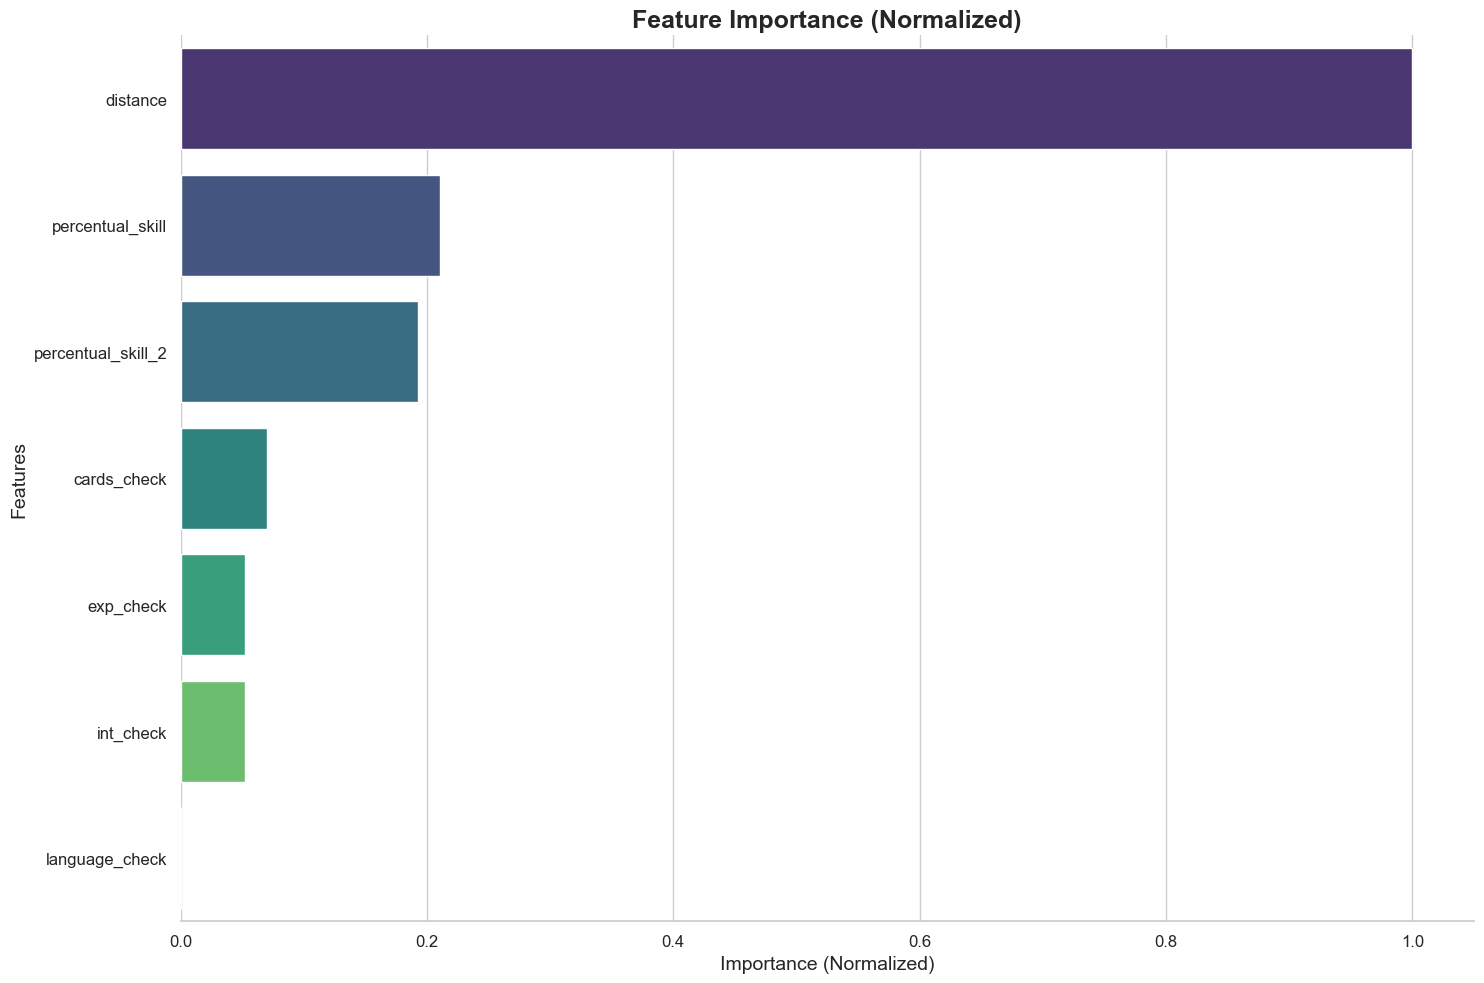

In [60]:
# Extract feature importance
feature_importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

# Normalize feature importance
max_importance = np.max(feature_importance)
normalized_importance = feature_importance / max_importance

# Create a DataFrame to hold the feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': normalized_importance
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot using seaborn with customized style
plt.figure(figsize=(15, 10))  
sns.set(style='whitegrid')  
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')  #
plt.title('Feature Importance (Normalized)', fontsize=18, fontweight='bold')  
plt.xlabel('Importance (Normalized)', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True)  # Remove left spine
plt.tight_layout()  
plt.show()

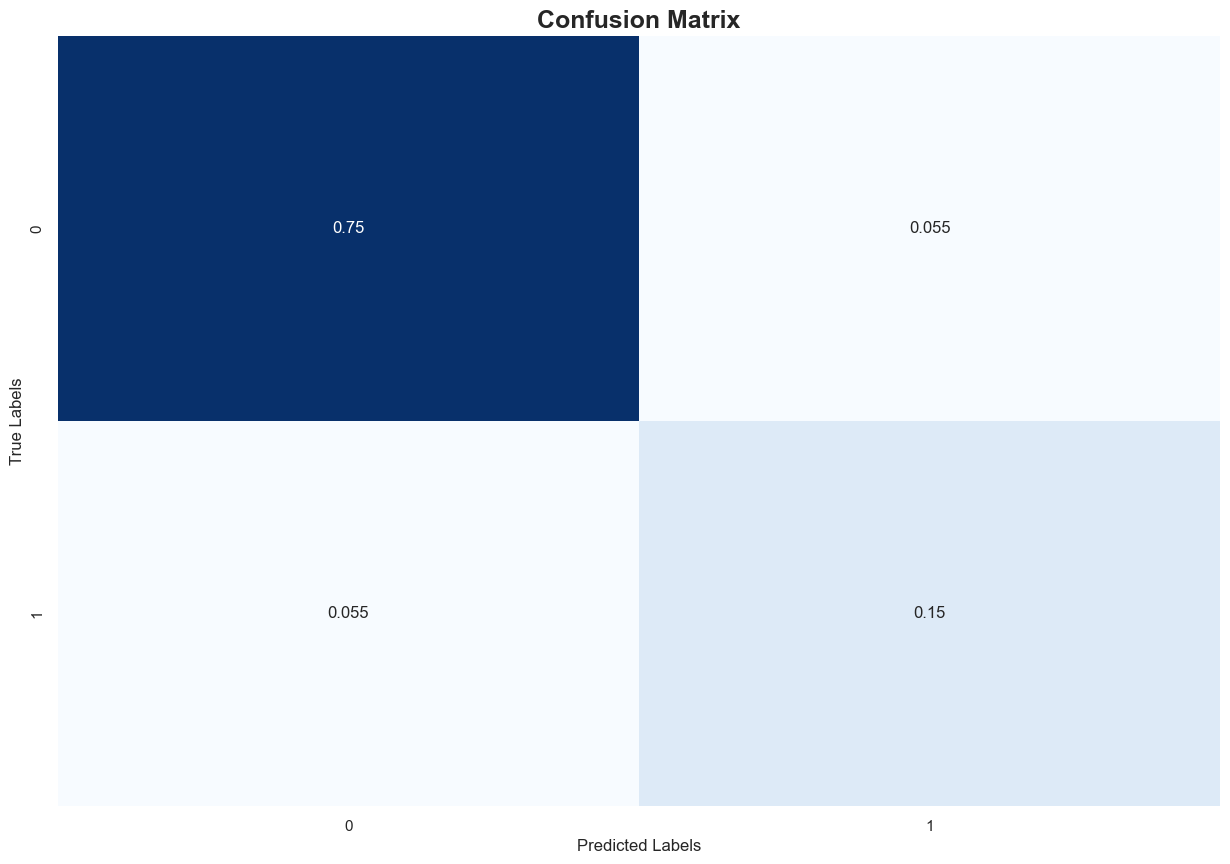

In [61]:
# Calculus of the Confusion matrix
cm = confusion_matrix(y_test.loc[X_test.index], X_test['pred'], normalize='all')

# Plot della confusion matrix
plt.figure(figsize=(15, 10)) 
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Given these results in the **Feature Importance Plot** we chose to drop the `language_check` feature and retrain the model since it's contribution in the model is neglectable. 

In [62]:
# Initialization of the new model for the train 
X = final_df[[ 'cards_check', 'distance', 'exp_check', 'int_check', 'percentual_skill', 'percentual_skill_2','Job_ID']]
y = final_df['Match']  

# splitting for cross validation
train_ids, test_ids = train_test_split(final_df['Job_ID'].unique(), test_size=0.2, random_state=42)
X_train = X[X['Job_ID'].isin(train_ids)].copy()
X_test = X[X['Job_ID'].isin(test_ids)].copy()
y_train = y[X['Job_ID'].isin(train_ids)].copy()
y_test = y[X['Job_ID'].isin(test_ids)].copy()

# number of candidate for each job
job_groups_train = X_train.groupby('Job_ID').size().to_numpy()
job_groups_test = X_test.groupby('Job_ID').size().to_numpy()

X_train.drop(columns=['Job_ID'], inplace=True)
X_test.drop(columns=['Job_ID'], inplace=True)

lgb_train = lgb.Dataset(X_train, y_train, group=job_groups_train)
lgb_test = lgb.Dataset(X_test, y_test, group=job_groups_test, reference=lgb_train)

# Creation of the Model and prediction
model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_test], valid_names=['train', 'valid'], num_boost_round=1000)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 311
[LightGBM] [Info] Number of data points in the train set: 10120, number of used features: 6
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	train's ndcg@1: 0.999506	train's ndcg@2: 0.997906	train's ndcg@3: 0.997151	train's ndcg@4: 0.996719	train's ndcg@5: 0.998987	valid's ndcg@1: 0.996055	valid's ndcg@2: 0.993003	valid's ndcg@3: 0.992331	valid's ndcg@4: 0.993921	valid's ndcg@5: 0.997495


In [63]:
# Predictions on the new rain test
y_pred = model.predict(X_test)

In [64]:
X_test['y_pred'] = y_pred
X_test['Job_ID'] = final_df.loc[X_test.index, 'Job_ID']

In [65]:
best_candidates = X_test.loc[X_test.groupby('Job_ID')['y_pred'].idxmax()]

X_test['pred'] = 0
X_test.loc[best_candidates.index, 'pred'] = 1

# Evaluation of the accuracy on the Train
accuracy = accuracy_score(y_test.loc[X_test.index], X_test['pred'])
print('New Accuracy:', accuracy)

New Accuracy: 0.9013806706114399


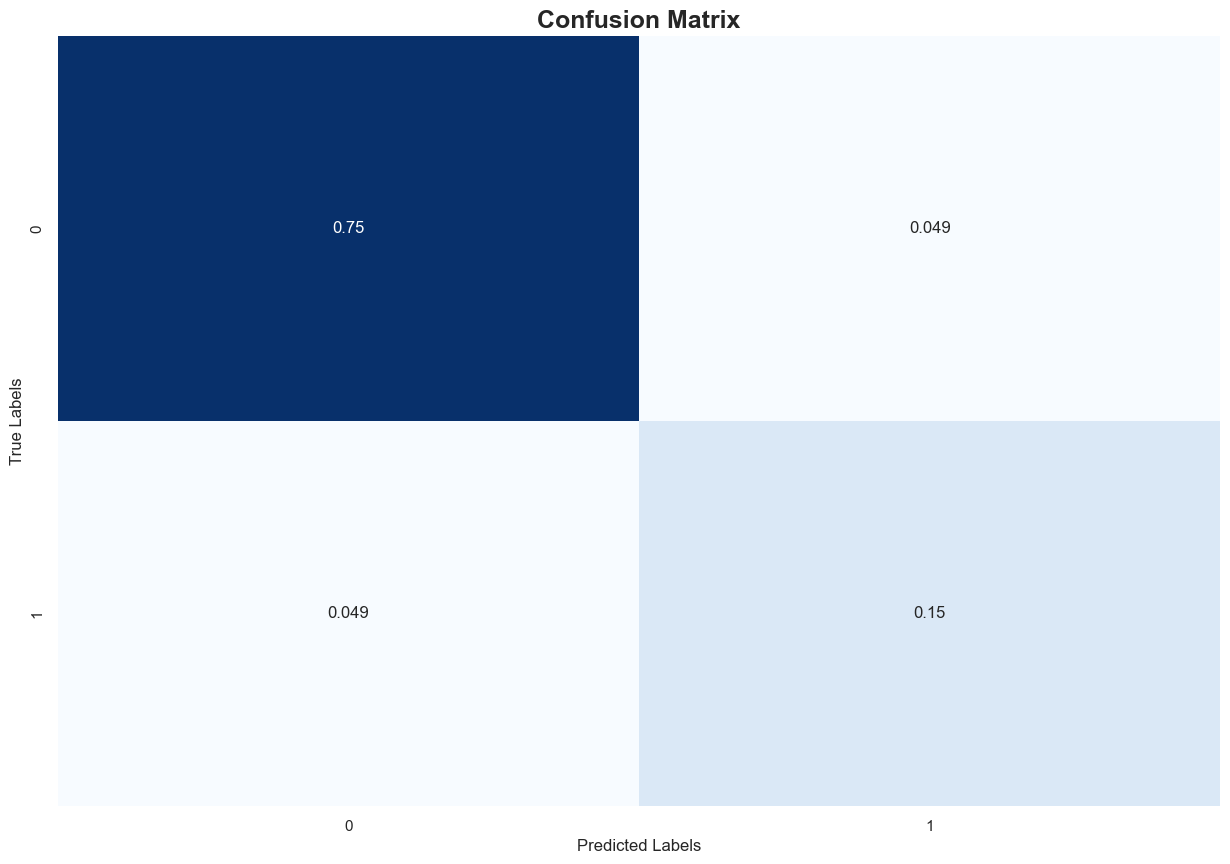

In [66]:
# Calculus of the New Confusion matrix
cm = confusion_matrix(y_test.loc[X_test.index], X_test['pred'], normalize='all')

# Plot della confusion matrix
plt.figure(figsize=(15, 10)) 
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
plt.title('Confusion Matrix', fontsize=18, fontweight='bold')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

---

Now we are going to apply this model on the Test set. Also in this case we chose to drop the `language_check` feature.

In [67]:
X_test = final_df_test[['cards_check', 'distance', 'exp_check', 'int_check', 'percentual_skill', 'percentual_skill_2']]
X_test['Job_ID'] = final_df_test['Job_ID']
job_groups_test = X_test.groupby('Job_ID').size().to_numpy()
X_test = X_test.drop(['Job_ID'], axis=1)

/var/folders/kb/y2wpyfkn7rj91tcfycy6yhlm0000gn/T/ipykernel_8618/1820806873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Job_ID'] = final_df_test['Job_ID']


In [68]:
y_pred = model.predict(X_test)

In [69]:
X_test['y_pred'] = y_pred

In [70]:
X_test['Job_ID'] = final_df_test['Job_ID']
best_candidates = X_test.loc[X_test.groupby('Job_ID')['y_pred'].idxmax()]

In [71]:
# We took the order for the output from the file

with open('/Users/francescolazzari/Documents/Università - Data Science/SL/Homework/SUS/Data/job_id_list_test.txt', 'r') as f:
    job_id_list_test = [(line.strip()) for line in f]
    
    
ordered = pd.DataFrame(job_id_list_test)
aux = final_df_test["CANDIDATE_ID"]
X_test["CANDIDATE_ID"] = aux

In [72]:
# picking only the candidate with the best score

idx = X_test.groupby('Job_ID')['y_pred'].idxmax()

In [73]:
# reordering

best_rows=X_test.loc[idx]
best_rows_copy = best_rows.copy()
df_sorted = ordered.merge(best_rows_copy, left_on = 0, right_on = "Job_ID", how = "left" )
submit=df_sorted['CANDIDATE_ID']

In [74]:
# creation of the file for the submission
with open('sub14.txt', 'w') as f:
    for candidate_id in submit:
        f.write(f"{candidate_id}\n")

print("File sub14.txt created with success.")

File sub14.txt created with success.
